# Overview
This notebook identifies significant r values
* fisherZ correct
* stack across participants and runs
* run t-test and identify r values greater than 0
* reconvert fisherZ back to correlation coefficients
* stack coefficients across hemisphere for multiple comparisons
* save results in corresponding hemisphere while preserving medial/non-medial wall vertices

# Updates Aug/2024
* comb-r2
* Need to grab comb-r2 instead of agents-r or bg-r.
* difference test -> only test against positive values

### modules

In [1]:
import numpy as np
import pandas as pd
import os
from os.path import join
import scipy.stats
from statsmodels.stats.multitest import multipletests
import nibabel as nib
from pathlib import Path
import matplotlib.pyplot as plt

### function: write_gifti

In [2]:
def write_gifti_v2(data, output_fn, template_fn):
    gii = nib.load(template_fn)
    for i in np.arange(gii.numDA):
        gii.remove_gifti_data_array(0)
    gda = nib.gifti.GiftiDataArray(data)
    gii.add_gifti_data_array(gda)
    # nib.gifti.write(gii, output_fn)
    gii.to_filename(output_fn)

In [3]:
def bootstrap_test(data, n_resample=1000, estimator=np.mean, axis=0):
    n_subjects = data.shape[axis]
    true_stat = estimator(data, axis=axis)
    boot_dist = []
    for i in np.arange(n_resample):
        boot_ids = np.random.choice(np.arange(n_subjects), size=n_subjects,replace=True)
        boot_sample = data[boot_ids]
        boot_stat = estimator(boot_sample, axis=axis)
        boot_dist.append(boot_stat)
    boot_dist = np.array(boot_dist)
    boot_null = boot_dist - true_stat
    p = (np.sum(boot_null >= true_stat, axis=axis) + 1) / (n_resample + 1)
    return p

def fisher_mean(correlation, axis=None):
    return np.tanh(np.nanmean(np.arctanh(correlation), axis=axis))


# parameters for Nested "agents bg moten" -- isolate "actions"
TODO: 
1. load comb-r2 for full model & comb-r2 for glove_nested_agents-bg-moten -> 
   * uniq = (comb_r2_full - comb_r2_nested) / comb_r2_full
2. Do this iteratively for all nested models (total of 3)
3. t-tests of uniq against 0. 
4. brain map: masked unique proportion R2, based on fdr-corrected t values. (Expected to be similar to Figure 1. )

In [4]:
suma_dir = '/Users/h/suma-fsaverage6'
main_dir = '/dartfs/rc/lab/D/DBIC/DBIC/f0042x1/life-encoding'
main_dir = '/Volumes/life-encoding'
features = 'agents-bg-moten'
nested_list = ['comb']#['agents', 'bg', 'moten']
nested_list_r = [item + '-r' for item in nested_list]
ANALYSIS="agents-bg-moten" # agents

full_dir = os.path.join(main_dir, 'results', 'himalaya', 'glove', 'agents-bg-moten', 'ha_common_pca-40')
nested_dir = os.path.join(main_dir, 'results', 'himalaya', 'glove_nested', 'agents-bg-moten', 'ha_common_pca-40')
alignment = 'ha_common'

runs = [1, 2, 3, 4]
hemis = ['lh', 'rh']
pca_comp = 40
fmri_durs = {1: 374, 2: 346, 3: 377, 4: 412}
n_samples = 1509
n_vertices = 40962
n_medial = {'lh': 3486, 'rh': 3491}
subjects = ['sub-rid000001', 'sub-rid000005', 'sub-rid000006',
            'sub-rid000009', 'sub-rid000012', 'sub-rid000014',
            'sub-rid000017', 'sub-rid000019', 'sub-rid000024',
            'sub-rid000027', 'sub-rid000031', 'sub-rid000032',
            'sub-rid000033', 'sub-rid000034', 'sub-rid000036',
            'sub-rid000037', 'sub-rid000038', 'sub-rid000041']



# compute one sample t-tests

In [35]:


r_type = 'r'

# directories __________________________________________________________________
full_dir = os.path.join(main_dir, 'results', 'himalaya', 'glove', 'ha_common_pca-40')
nested_dir = os.path.join(main_dir, 'results', 'himalaya', 'glove_nested', 'agents-bg-moten', 'ha_common_pca-40')
output_dir = os.path.join(main_dir, 'results', 'himalaya', 'glove_nested', 'agents-bg-moten', 'variancepart')

# initialize t, p, mean values
hemi_t = []
hemi_p = []
hemi_mean = []

print(f"starting nested vs full model ________________")
for hemisphere in hemis:
    medial_mask = np.load(os.path.join(main_dir, 'data', f'fsaverage6_medial_{hemisphere}.npy'))
    assert np.sum(medial_mask) == n_medial[hemisphere]
    cortical_vertices = ~medial_mask # boolean (true for non-medials, false for medials)
    cortical_coords = np.where(cortical_vertices)[0] # returns indices of non-medials
    avg_all = []
    
    # NOTE 1. stack full data and nested data
    for test_subject in subjects:
        stack_fullrun = []
        stack_nestedrun = []

        for test_run in runs:           
            full_data = np.load(f"{full_dir}/comb-{r_type}_pca-{pca_comp}_align-{alignment}_{test_subject}_run-{test_run}_hemi-{hemisphere}.npy")
            # fisherz_p1run = np.arctanh(full_data[0, cortical_vertices])
            stack_fullrun.append(full_data)#fisherz_p1run)

            nested_data = np.load(f"{nested_dir}/comb-{r_type}_pca-{pca_comp}_align-{alignment}_{test_subject}_run-{test_run}_hemi-{hemisphere}.npy")
            # fisherz_p2run = np.arctanh(nested_data[0, cortical_vertices])
            stack_nestedrun.append(nested_data) #fisherz_p2run)
    
        # NOTE: 2. average R2 or R values across runs: yields 18 maps (1 per subject)
        stack_full = np.vstack(stack_fullrun)
        stack_nested = np.vstack(stack_nestedrun)
        diff = stack_full - stack_nested

        # avg_run = np.mean(diff, axis = 0)
        avg_run = fisher_mean(diff, axis=0)
        avg_all.append(avg_run)
    diff_all = np.vstack(avg_all) # 18 x nonmedial (per hemi)

    # NOTE: 3. Scipy ttest_1samp to get t-value and p-value
    # t, p = scipy.stats.ttest_1samp(diff_all, popmean=0, axis=0, alternative='greater')
    p = bootstrap_test(diff_all, n_resample=10000, estimator=fisher_mean, axis=0)

    # NOTE: boothstrap here
    # hemi_t.append(t)
    hemi_p.append(p)
    hemi_mean.append(fisher_mean(diff_all, axis=0))

# %% NOTE: 4-1. concatenate (np.hstack) the two hemispheres p-values (and exclude medial wall) prior to computing FDR (load in cortical_vertices.npy)
left_vert = hemi_p[0].shape[0]
# t_all = np.hstack(hemi_t)
p_all = np.hstack(hemi_p)

reject, q_all, _, _ = multipletests(p_all, method = 'fdr_bh')
q_both = [q_all[:left_vert], q_all[left_vert:]]
print("* completed t-tests for both hemispheres")
hemilabels = ['lh', 'rh']
Path(join(output_dir)).mkdir(parents = True, exist_ok = True)
fdr_thres = .05
for h, hemisphere in enumerate(hemis):
    stats = np.zeros((n_vertices))
    hemi_mean[h][q_both[h] >= fdr_thres] = 0
    medial_mask = np.load(os.path.join(main_dir, 'data', f'fsaverage6_medial_{hemisphere}.npy'))
    assert np.sum(medial_mask) == n_medial[hemisphere]
    cortical_vertices = ~medial_mask # boolean (true for non-medials, false for medials)
    cortical_coords = np.where(cortical_vertices)[0] # returns indices of non-medials
    stats[cortical_coords] = hemi_mean[h][cortical_coords]
    save_fname = f"{output_dir}/variance-{r_type}_{features}_pca-{pca_comp}_align-{alignment}_hemi-{hemisphere}_ttest.gii"
    write_gifti_v2(stats.astype(np.float32),
    template_fn = os.path.join(suma_dir, f"{hemilabels[h]}.pial.gii"), 
    output_fn = save_fname)
print("* saved output (thresholded average r) for both hemispheres")


starting nested vs full model ________________


/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_14888/1082796974.py:16: RuntimeWarning: Mean of empty slice
  return np.tanh(np.nanmean(np.arctanh(correlation), axis=axis))


* completed t-tests for both hemispheres
* saved output (thresholded average r) for both hemispheres


In [36]:
print(f"shape of p: {p.shape}")

shape of p: (40962,)


In [5]:
np.nanmean(diff_all[0])
print(f"mean: {np.nanmean(diff_all[3])}")
print(f"min: {np.nanmin(diff_all[3])}")
print(f"max: {np.nanmax(diff_all[3])}")
# stack_nested

NameError: name 'diff_all' is not defined

In [38]:
np.nanmean(stack_full[0])
print(f"mean: {np.nanmean(stack_full[3])}")
print(f"min: {np.nanmin(stack_full[3])}")
print(f"max: {np.nanmax(stack_full[3])}")
# stack_nested

mean: 0.029297420472398205
min: -0.2278374284505844
max: 0.35331469774246216


## r values

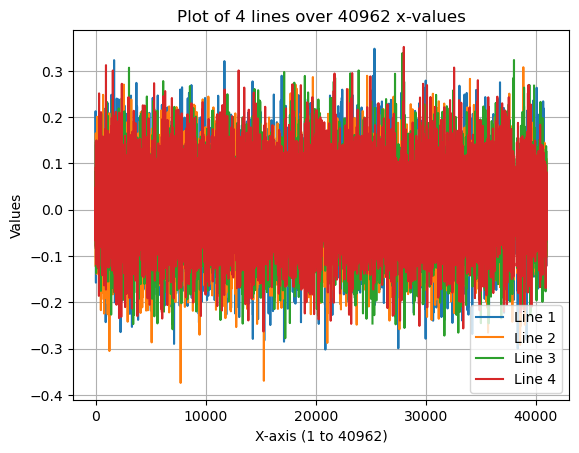

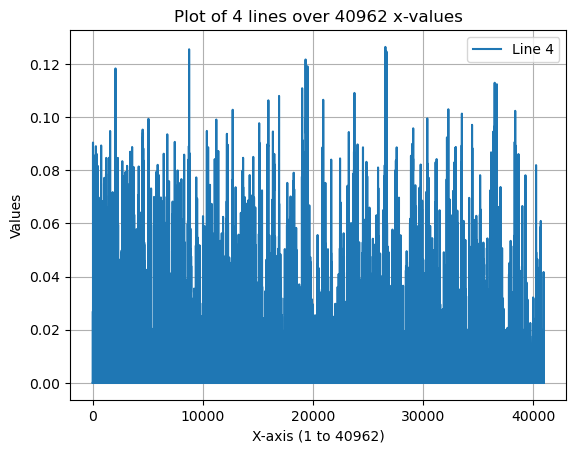

In [39]:
# plot values per run
for i in range(diff.shape[0]):
    plt.plot(np.arange(0, diff.shape[1]), diff[i], label=f'Line {i+1}')

plt.xlabel('X-axis (1 to 40962)')
plt.ylabel('Values')
plt.title('Plot of 4 lines over 40962 x-values')
plt.legend()
plt.grid(True)
plt.show()

# stacked average -> plot values
plt.plot(np.arange(0, hemi_mean[0].shape[0]), hemi_mean[0], label=f'Line {i+1}')

plt.xlabel('X-axis (1 to 40962)')
plt.ylabel('Values')
plt.title('Plot of 4 lines over 40962 x-values')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
diff.shape

(4, 40962)

In [41]:
np.nanmean(stack_full[0])
print(np.nanmean(stack_full[3]))
print(np.nanmin(stack_full[3]))
print(np.nanmax(stack_full[3]))
# stack_nested

# print(np.nanmean(diff[3]))
# print(np.nanmin(diff[3]))
# print(np.nanmax(diff[3]))

0.029297420472398205
-0.2278374284505844
0.35331469774246216


# plot results in fslr

plot t-test results in surfplots, Freesurfer surface plots

In [6]:
from neuromaps.datasets import fetch_fsaverage, fetch_fslr
import numpy as np
from surfplot import Plot
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib import colors
from os.path import join
import nibabel as nib
surfaces = fetch_fsaverage()
lh, rh = surfaces['inflated']
main_dir = '/Volumes/life-encoding'
output_dir = os.path.join(main_dir, 'results', 'himalaya', 'glove_nested', 'agents-bg-moten', 'variancepart')
alignment = 'ha_common'

In [7]:
def fsaverage_to_fslr_and_plot(Lfname, Rfname, key, cmap='inferno', min=0, max=.05):#,min=-40, max=40):
    from neuromaps.datasets import fetch_fslr
    from neuromaps.transforms import fsaverage_to_fslr
    giiL = nib.load(Lfname)
    giiR = nib.load(Rfname)
    L_fslr = fsaverage_to_fslr(giiL, target_density='32k', hemi='L', method='linear')
    R_fslr = fsaverage_to_fslr(giiR, target_density='32k', hemi='R', method='linear')
    
    surfaces_fslr = fetch_fslr()
    lh_fslr, rh_fslr = surfaces_fslr['inflated']
    # color_range = (min,max)
    color_range = (min,max)
    p = Plot(surf_lh=lh_fslr, 
             surf_rh=rh_fslr, 
             size=(1000, 200), 
             zoom=1.2, layout='row', 
             views=['lateral', 'medial', 'ventral', 'posterior'], 
             mirror_views=True, brightness=.5)
    p.add_layer({'left': L_fslr[0], 
                'right': R_fslr[0]}, 
                cmap=cmap, cbar=True,
                color_range=color_range,
                cbar_label=key
                ) # YlOrRd_r
    cbar_kws = dict(outer_labels_only=True, pad=.02, n_ticks=2, decimals=3)
    fig = p.build(cbar_kws=cbar_kws)
    # fig.show()
    return(fig)


## r values

In [8]:
output_dir

'/Volumes/life-encoding/results/himalaya/glove_nested/agents-bg-moten/variancepart'

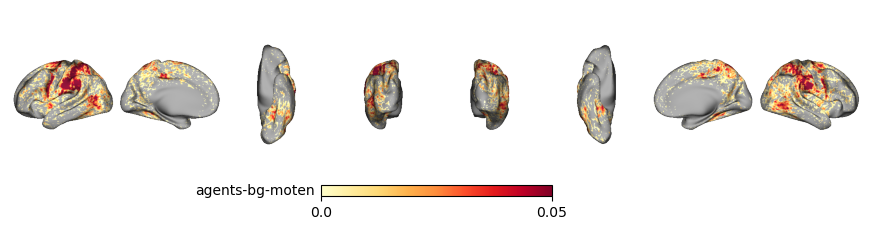

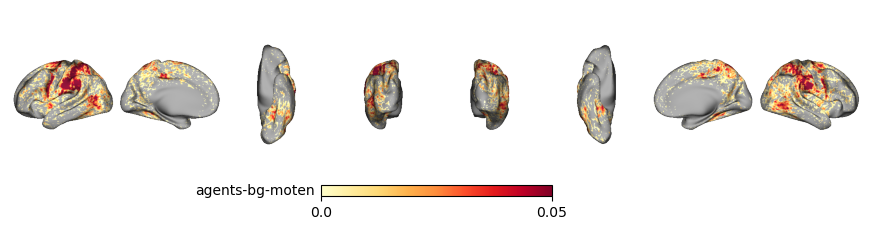

In [9]:
alignment = 'ha_common'
r_type = 'r'

bgLfname = f"{output_dir}/variance-{r_type}_{features}_pca-40_align-{alignment}_hemi-lh_ttest.gii"
bgRfname = f"{output_dir}/variance-{r_type}_{features}_pca-40_align-{alignment}_hemi-rh_ttest.gii"
fsaverage_to_fslr_and_plot(bgLfname, bgRfname, features, cmap='YlOrRd', min=0, max=.05)

## count significant voxels
How many voxels are significant per stat map (FDR-corrected)?

In [10]:
alignment = 'ha_common'
output_dir = os.path.join(main_dir, 'results', 'himalaya', 'glove_nested', 'agents-bg-moten', 'variancepart')

Lfname = f"{output_dir}/variance-{r_type}_{features}_pca-40_align-{alignment}_hemi-lh_ttest.gii"
Rfname = f"{output_dir}/variance-{r_type}_{features}_pca-40_align-{alignment}_hemi-rh_ttest.gii"

giiL = nib.load(Lfname)
giiR = nib.load(Rfname)

sig_voxel = np.sum(giiL.agg_data() > 0) + np.sum(giiR.agg_data() > 0) 
print(f"variance partition: {sig_voxel}")


variance partition: 26404


# cluster thresholded

We threshold the maps using work bench. The output is a (semi) boolean mask, thereby, we apply the mask back onto the t-test maps. 
Steps include
* Workbench cluster threshold
* multiply workbench mask with t-test maps
* plot thresholded maps

### workbench cluster threshold

In [11]:
from subprocess import call
# parameteres
hemis = ['lh', 'rh']
# features = ['bg', 'agents', 'actions', 'moten']
clustersize = 50
hemi_dict = {'lh': 'L', 'rh': 'R'}
fsaverage_dir = '/Users/h/neuromaps-data/atlases/fsaverage'
data_dir = f'/Volumes/life-encoding/results/himalaya/glove_nested/{features}/variancepart'
r_type = 'r'
# thresholding via workbench
for hemi in hemis:
    for feature in nested_list:
        fsaverage_template = f"{fsaverage_dir}/tpl-fsaverage_den-41k_hemi-{hemi_dict[hemi]}_inflated.surf.gii"
        himalaya = f"{data_dir}/variance-{r_type}_{features}_pca-40_align-ha_common_hemi-{hemi}_ttest.gii"
        outputfname = f"{data_dir}/variance-{r_type}_{features}_pca-40_align-ha_common_hemi-{hemi}_ttest_cluster-{clustersize}.gii"
        return_code = call(f"wb_command -metric-find-clusters {fsaverage_template} {himalaya} 0 {clustersize} {outputfname}", shell=True)
        
print(f"Return: {return_code}")

Return: 0


## check cluster maps
The images will look like masks

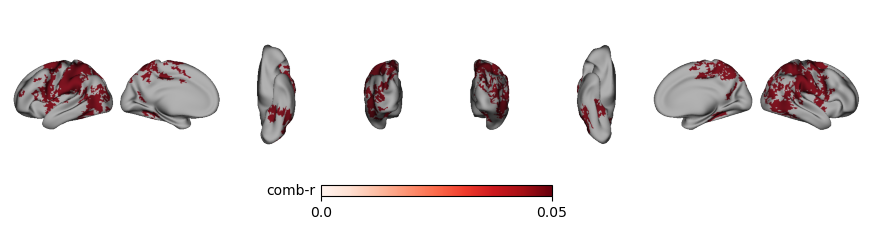

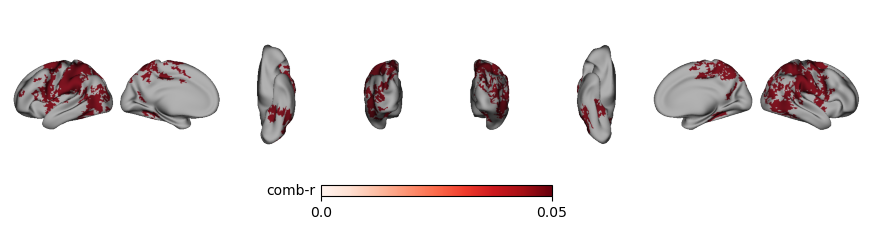

In [12]:
clusterthresL = f"{data_dir}/variance-{r_type}_{features}_pca-40_align-ha_common_hemi-lh_ttest_cluster-{clustersize}.gii"
clusterthresR = f"{data_dir}/variance-{r_type}_{features}_pca-40_align-ha_common_hemi-rh_ttest_cluster-{clustersize}.gii"
fsaverage_to_fslr_and_plot(clusterthresL, clusterthresR, f'{feature}-r', cmap = 'Reds', min=0, max=.05)

## multiply workbench cluster threshold maps to t-test maps

In [14]:
clustersize

50

In [15]:
def write_gifti_v2(data, output_fn, template_fn):
    gii = nib.load(template_fn)
    for i in np.arange(gii.numDA):
        gii.remove_gifti_data_array(0)
    gda = nib.gifti.GiftiDataArray(data)
    gii.add_gifti_data_array(gda)
    # nib.gifti.write(gii, output_fn)
    gii.to_filename(output_fn)

hemis = ['lh', 'rh']
hemi_dict = {'lh': 'L', 'rh': 'R'}


fsaverage_dir = '/Users/h/neuromaps-data/atlases/fsaverage'
data_dir = f'/Volumes/life-encoding/results/himalaya/glove_nested/{features}/variancepart'

# thresholding via workbench
for hemi in hemis:
    for feature in nested_list: #features:
        clustermask_fname = f"{data_dir}/variance-{r_type}_{features}_pca-40_align-ha_common_hemi-{hemi}_ttest_cluster-{clustersize}.gii"
        clustL = nib.load(clustermask_fname).agg_data() > 0
        himalaya_fname = f"{data_dir}/variance-{r_type}_{features}_pca-40_align-ha_common_hemi-{hemi}_ttest.gii"
        himalaya = nib.load(himalaya_fname).agg_data()
        maskeddata = clustL * himalaya
        write_gifti_v2(maskeddata.astype(np.float32), 
            output_fn=f"{data_dir}/variance-{r_type}_{features}_pca-40_align-{alignment}_hemi-{hemi}_ttest_thres-cluster{clustersize}.gii",
            template_fn=f"{fsaverage_dir}/tpl-fsaverage_den-41k_hemi-{hemi_dict[hemi]}_pial.surf.gii")

## plot thresholded maps in fslr [manuscript]

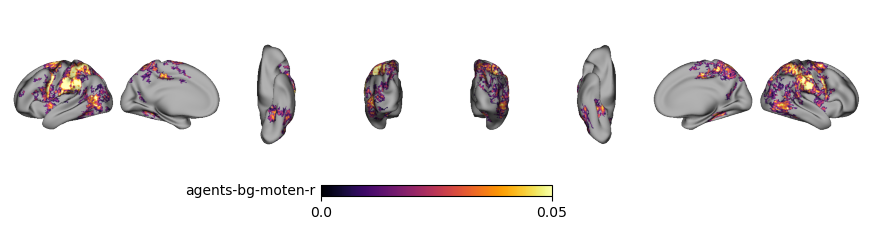

In [16]:
save_dir = f'/Users/h/Documents/projects_local/life-encoding/figure/glove_nested/{features}/variancepart'

save_dir = f'/Users/h/jung2heejung@gmail.com - Google Drive/My Drive/life_encoding/figure/glove_nested/variancepart'

Path(save_dir).mkdir(exist_ok=True, parents=True)
for feature in nested_list: #['bg', 'agents', 'actions', 'moten']:
    thresL = f"{data_dir}/variance-{r_type}_{features}_pca-40_align-{alignment}_hemi-lh_ttest_thres-cluster{clustersize}.gii"
    thresR = f"{data_dir}/variance-{r_type}_{features}_pca-40_align-{alignment}_hemi-rh_ttest_thres-cluster{clustersize}.gii"
    fig = fsaverage_to_fslr_and_plot(thresL, thresR, f'{features}-r', cmap='inferno',min=0, max=.05)
    fig.savefig(join(save_dir, f"{features}-r_pca-40_align-{alignment}_hemi-lh_ttest_thres-cluster{clustersize}.png"), dpi=300)

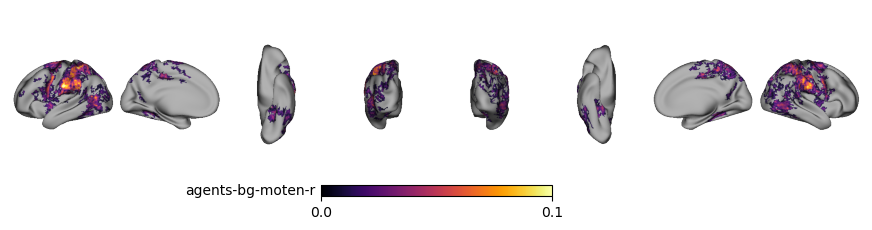

: 

In [18]:
save_dir = f'/Users/h/Documents/projects_local/life-encoding/figure/glove_nested/{features}/variancepart'

save_dir = f'/Users/h/jung2heejung@gmail.com - Google Drive/My Drive/life_encoding/figure/glove_nested/variancepart'

Path(save_dir).mkdir(exist_ok=True, parents=True)
for feature in nested_list: #['bg', 'agents', 'actions', 'moten']:
    thresL = f"{data_dir}/variance-{r_type}_{features}_pca-40_align-{alignment}_hemi-lh_ttest_thres-cluster{clustersize}.gii"
    thresR = f"{data_dir}/variance-{r_type}_{features}_pca-40_align-{alignment}_hemi-rh_ttest_thres-cluster{clustersize}.gii"
    fig = fsaverage_to_fslr_and_plot(thresL, thresR, f'{features}-r', cmap='inferno',min=0, max=.10)
    fig.savefig(join(save_dir, f"{features}-r_pca-40_align-{alignment}_hemi-lh_ttest_thres-cluster{clustersize}10.png"), dpi=300)

In [17]:
print(f"min: {np.nanmin(nib.load(thresL).agg_data())}")
print(f"max: {np.nanmax(nib.load(thresL).agg_data())}")

min: 0.0
max: 0.12635059654712677
